In [142]:
# imports
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import re
import seaborn as sns
import time

from scipy import stats
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

In [143]:
# -- ARCHIVED --
# upload / download models and logs to tensorboard

# copy relevant model metrics into seperate folder and upload to tensorboard dev
# data_filter = 'test' # 'train', 'test' or 'validation'
# model_filter = 'resnet'# 'basic' or 'resnet'
# log_path = '../logs/scalars'
# upload_path = '../tensorboard_upload/'
# os.mkdir(upload_path)

# for (dirpath, dirnames, filenames) in os.walk(log_path):
#     # filter dirs
#     if data_filter in dirpath and model_filter in dirpath:

#         from_directory = dirpath
#         to_directory = upload_path + dirpath[16:]

#         # copy dir trees
#         shutil.copytree(from_directory, to_directory)

# # TODO: run in project root for upload
# print(f'tensorboard dev upload --logdir=./tensorboard_upload/ --name FLE_{model_filter}_{data_filter}')

# # remove copied dir trees
# shutil.rmtree(upload_path)

# # TODO: set tensorboard dev ID
# experiment_ids = ['0m4NvD5jTxmSw3hr8SeJww', 'uLYWP18zQ1eMtDBiLHLHrg'] # [resnet, basic]
# all_dfs = []

# # download experiments
# for ind, id in enumerate(experiment_ids):
#     experiment = tb.data.experimental.ExperimentFromDev(id)
#     df_temp = experiment.get_scalars()
    
#     print(f'{ind}: {df_temp.shape}')
#     all_dfs.append(df_temp)

# # combine experiments into single dataframe
# df = all_dfs[0]

# if len(all_dfs) > 1:
#     for new_df in all_dfs[1:]:
#         df = pd.concat([df, new_df])

# print(df.shape)
# df.head()

In [144]:
# define path and file filter
log_path = '../logs/class_report'
filter = 'class_report_19epoch.json'

# define metrics to be extracted as list
logs = [['accuracy']
        , ['macro avg', 'precision']
        , ['macro avg', 'recall']
        , ['macro avg', 'f1-score']
        , ['weighted avg', 'precision']
        , ['weighted avg', 'recall']
        , ['weighted avg', 'f1-score']
]

# init dataframe
df_headers = ['run', 'model', 'ratio', 'classes', 'metric', 'value']
df = pd.DataFrame(columns=df_headers)

# iter through logs and get metrics from classification report jsons
counter = 0
for (dirpath, dirnames, filenames) in os.walk(log_path):

    if filter in filenames:
        counter += 1

        file_path = dirpath+'/'+filter
        class_report = json.load(open(file_path))

        for log in logs:

            run = dirpath.split('\\', 1)[-1].replace('\\', '_')
            model = re.search('(^[a-z]{5,6})_', run).group(1)
            ratio = float(re.search('(\d{5})r', run).group(1)) / 100
            classes = re.search('(\d{1,2})c', run).group(1)
            
            if len(log) == 1:
                metric = log[0]
                value = class_report[log[0]]
            elif len(log) == 2:
                metric = log[0] + ' ' + log[1]
                value = class_report[log[0]][log[1]]
            
            row = [
                str(run),
                str(model),
                float(ratio),
                str(classes),
                str(metric),
                float(value)
            ]

            df_len = len(df)
            df.loc[df_len] = row

print(f'{counter} classification reports found - df.shape {df.shape}')
df.head()

699 classification reports found - df.shape (4893, 6)


,run,model,ratio,classes,metric,value
0,basic_00000r_14c_20220413-1643,basic,0.0,14,accuracy,0.844503
1,basic_00000r_14c_20220413-1643,basic,0.0,14,macro avg precision,0.818496
2,basic_00000r_14c_20220413-1643,basic,0.0,14,macro avg recall,0.805868
3,basic_00000r_14c_20220413-1643,basic,0.0,14,macro avg f1-score,0.807963
4,basic_00000r_14c_20220413-1643,basic,0.0,14,weighted avg precision,0.853091


In [145]:
df['metric'].unique()

array(['accuracy', 'macro avg precision', 'macro avg recall',
       'macro avg f1-score', 'weighted avg precision',
       'weighted avg recall', 'weighted avg f1-score'], dtype=object)

In [146]:
# check wich training setups have less than 20 runs
df_runs = df.groupby(['model', 'ratio', 'classes', 'metric']).count().reset_index()
df_runs = df_runs.drop('value', axis=1).query('metric == "accuracy"')
df_runs.query('run < 20').sort_values(by=['model', 'ratio', 'classes'], axis=0)

,model,ratio,classes,metric,run
0,basic,0.00,14,accuracy,15
14,basic,0.25,14,accuracy,15
28,basic,0.50,14,accuracy,15
42,basic,1.00,14,accuracy,15
56,basic,2.00,14,accuracy,15
63,basic,2.00,4,accuracy,19
70,basic,3.00,14,accuracy,15
84,basic,4.00,14,accuracy,15
98,basic,5.00,14,accuracy,15
112,basic,7.50,14,accuracy,15


--------------

## regression

In [147]:
# TODO: set regression parameters
regressand = 'accuracy' # regressand to use
use_delta = False # use regressand delta to 0 ratio model for regression
use_scaling = True # use scaling for regression
zscore_threshold = 3 # zscore threshold for removing outlier based on regressand

In [148]:
# preprocess dataframe

df_regression = df.query(f'metric == "{regressand}"')
df_regression = df_regression.rename(columns={'value': regressand})

df_tmp = df.groupby(['model', 'classes', 'ratio', 'metric']).mean().reset_index()
df_regression[f'{regressand}_delta'] = df_regression.apply(lambda row:
    row[regressand] - df_tmp.query(f'model=="{row.model}" & classes=="{row.classes}" & ratio==0.0 & metric=="{row.metric}"').iloc[0]['value'], axis=1
)

df_regression.drop(['run', 'metric'], axis=1, inplace=True)
df_regression = pd.get_dummies(
    df_regression,
    columns=['model', 'classes'],
    drop_first=True
)
df_regression.reset_index(inplace=True, drop=True)
print(df_regression.shape)
df_regression.head()

(699, 5)


,ratio,accuracy,accuracy_delta,model_resnet,classes_4
0,0.0,0.844503,0.000452,0,0
1,0.0,0.844503,0.000452,0,0
2,0.0,0.851280,0.007229,0,0
3,0.0,0.841114,-0.002937,0,0
4,0.0,0.847892,0.003840,0,0


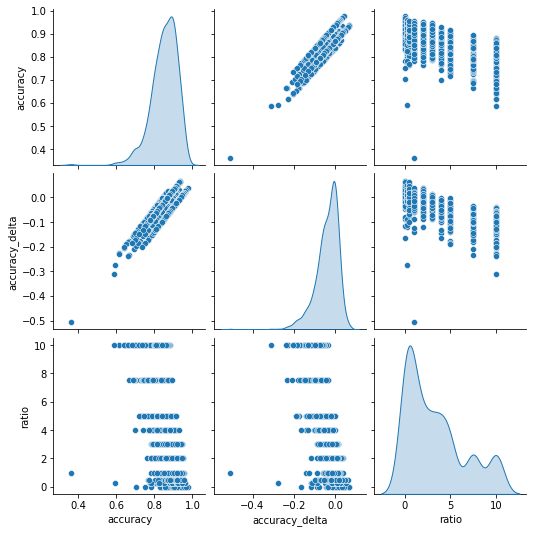

In [149]:
sns.pairplot(df_regression[[regressand, f'{regressand}_delta', 'ratio']], diag_kind='kde')

<AxesSubplot:xlabel='ratio', ylabel='accuracy'>

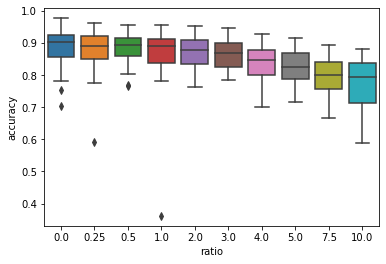

In [150]:
sns.boxplot(x='ratio', y=regressand, data=df_regression)

In [151]:
# filter outlier of regressand
mask = np.abs(stats.zscore(df_regression[regressand])) > zscore_threshold
print(f'{mask.sum()} rows filtered')

df_regression[regressand] = df_regression[regressand].mask(mask)

# show filtered rows
df_regression[df_regression[regressand].isna()]

# drop outliers
df_regression.dropna(inplace=True)

7 rows filtered


In [152]:
df_regression.describe()

,ratio,accuracy,accuracy_delta,model_resnet,classes_4
count,692.000000,692.000000,692.000000,692.000000,692.000000
mean,3.286488,0.853173,-0.039354,0.502890,0.575145
std,3.143923,0.062265,0.050818,0.500353,0.494679
min,0.000000,0.653614,-0.237613,0.000000,0.000000
25%,0.500000,0.813159,-0.066703,0.000000,0.000000
50%,2.000000,0.860316,-0.029669,1.000000,1.000000
75%,5.000000,0.899849,-0.002871,1.000000,1.000000
max,10.000000,0.976657,0.068122,1.000000,1.000000


In [153]:
# get independent and dependent variables
if use_delta:
    X_df = df_regression[[f'{regressand}_delta']]
else:
    X_df = df_regression[[regressand]]
y_df = df_regression['ratio']

for column in X_df.columns:
    r, p = stats.pearsonr(X_df[column], y_df)
    print(f'{round(r, 4)} pearsonr, {p} p-value, Variable: {column}')

# split data
X_train, X_test, y_train, y_test = train_test_split(
                                                X_df
                                                , y_df
                                                , test_size=0.15
                                                , stratify=y_df
                                            )

# scale X data
if use_scaling:
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

print(f'\nX_train.shape {X_train.shape} - y_train.shape {y_train.shape}\n\
X_test.shape {X_test.shape} - y_test.shape {y_test.shape}')

y_train.value_counts()

-0.5852 pearsonr, 8.127157597774929e-65 p-value, Variable: accuracy

X_train.shape (588, 1) - y_train.shape (588,)
X_test.shape (104, 1) - y_test.shape (104,)


0.00     60
4.00     60
0.25     59
0.50     59
1.00     59
2.00     59
3.00     59
5.00     59
7.50     59
10.00    55
Name: ratio, dtype: int64

In [154]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# initialize estimators and hyperparameter params for each estimator
regr_linear = LinearRegression()
regr_linear_params = {}

regr_lasso = Lasso()
regr_lasso_params = {}
regr_lasso_params['regr__max_iter'] = [10000]
regr_lasso_params['regr__alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0]
regr_lasso_params['regr__warm_start'] = [True, False]
regr_lasso_params['regr__selection'] = ['random', 'cyclic']

regr_elastic = ElasticNet()
regr_elastic_params = {}
regr_elastic_params['regr__max_iter'] = [10000]
regr_elastic_params['regr__alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0]
regr_elastic_params['regr__l1_ratio'] = np.linspace(0.001, 0.999, 10)
regr_elastic_params['regr__warm_start'] = [True, False]
regr_elastic_params['regr__selection'] = ['random', 'cyclic']

regr_ridge = Ridge()
regr_ridge_params = {}
regr_ridge_params['regr__max_iter'] = [10000]
regr_ridge_params['regr__alpha'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0]
regr_ridge_params['regr__solver'] = [
    'auto', 'svd', 'cholesky', 'lsqr'
    , 'sparse_cg', 'sag', 'saga'
]

regr_svr = SVR()
regr_svr_params = {}
regr_svr_params['regr__kernel'] = ['linear', 'poly', 'rbf'] # 'sigmoid'
regr_svr_params['regr__degree'] = [1, 2, 3]
regr_svr_params['regr__gamma'] = [1e-1, 1.0, 10.0]
# regr_svr_params['regr__coef0'] = [0.0, 0.1, 0.3, 0.8]
regr_svr_params['regr__C'] = [1e-1, 1.0, 10.0]
regr_svr_params['regr__epsilon'] = [1e-2, 1e-1, 1.0]

regr_randomForest = RandomForestRegressor()
regr_randomForest_params = {}
regr_randomForest_params['regr__n_estimators'] = [100, 200, 300, 400, 500]
regr_randomForest_params['regr__criterion'] = ['squared_error'] # 'absolute_error', 'poisson'
regr_randomForest_params['regr__max_depth'] = [1, 2, 3, 4, 5]
regr_randomForest_params['regr__warm_start'] = [True, False]

regr_gradientBoost = GradientBoostingRegressor()
regr_gradientBoost_params = {}
# regr_gradientBoost_params['regr__loss'] = ['squared_error', 'huber']
regr_gradientBoost_params['regr__learning_rate'] = [0.1, 0.2, 0.5, 0.7]
regr_gradientBoost_params['regr__n_estimators'] = [100, 200, 300, 400, 500]
# regr_gradientBoost_params['regr__criterion'] = ['friedman_mse', 'squared_error', 'absolute_error']
regr_gradientBoost_params['regr__max_depth'] = [1, 2, 3, 4, 5]
regr_gradientBoost_params['regr__alpha'] = [0.1, 0.5, 0.9]
regr_gradientBoost_params['regr__warm_start'] = [True, False]

models_and_params = [
    [regr_linear, regr_linear_params]
    , [regr_lasso, regr_lasso_params]
    , [regr_elastic, regr_elastic_params]
    , [regr_ridge, regr_ridge_params]
    , [regr_svr, regr_svr_params]
    , [regr_randomForest, regr_randomForest_params]
    , [regr_gradientBoost, regr_gradientBoost_params]
]

# initialize logging
log_path = Path('../logs/evauluation_log')
if not os.path.exists(log_path):
    os.mkdir(log_path)

# iterate over models and hyperparameters and train
best_params_per_model = {}
for model, params in models_and_params:
    model_name = f'{str(model)[:-2]}'
    
    # initialize pipeline with scaler and regressor
    pipe = Pipeline(
        steps = [
            # ('scaler', StandardScaler()),
            ('regr', model)
        ]
        # , verbose=True
    )

    # run gridsearch
    print('--------')
    start = time.time()

    gs = GridSearchCV(
        pipe
        , params
        # , n_iter=2
        , n_jobs=-2
        , cv=5
        , scoring='r2'
        , verbose=1
    ).fit(X_train, y_train)

    end = time.time()
    print(
        f'{model_name}'\
        f' - Training time elapsed: {round((end - start) / 60, 3)} min'\
        f' - Best score: {round(gs.best_score_, 3)}'
    )

    # add best params + score per model to dict
    best_params_per_model[model_name] = {
        'score': gs.best_score_,
        'best_params': gs.best_params_
    }

# file name depending on if regression is run on regressand delta or not
if use_delta:
    file_name = f'{regressand}_delta_regression_params.json'
else:
    file_name = f'{regressand}_regression_params.json'

# save best params per model
with open(f'{log_path}/{file_name}', 'w') as f:
    json.dump(best_params_per_model, f)

--------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
LinearRegression - Training time elapsed: 0.076 min - Best score: 0.342
--------
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Lasso - Training time elapsed: 0.034 min - Best score: 0.342
--------
Fitting 5 folds for each of 320 candidates, totalling 1600 fits
ElasticNet - Training time elapsed: 0.034 min - Best score: 0.342
--------
Fitting 5 folds for each of 56 candidates, totalling 280 fits
Ridge - Training time elapsed: 0.009 min - Best score: 0.342
--------
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
SVR - Training time elapsed: 3.769 min - Best score: 0.335
--------
Fitting 5 folds for each of 50 candidates, totalling 250 fits
RandomForestRegressor - Training time elapsed: 0.987 min - Best score: 0.324
--------
Fitting 5 folds for each of 600 candidates, totalling 3000 fits
GradientBoostingRegressor - Training time elapsed: 2.216 min - Best score: 0.326


In [155]:
# file name depending on if regression is run on regressand delta or not
if use_delta:
    file_name = f'{regressand}_delta_regression_params.json'
else:
    file_name = f'{regressand}_regression_params.json'

# read models with best params
with open(f'{log_path}/{file_name}', 'r') as f:
    regression_results = json.load(f)

# get best score / model
best_model = ''
best_train_score = 0

for model, results in regression_results.items():
    score = results["score"]
    print(f'{round(score,6)} - {model}')

    if score > best_train_score:
        best_train_score = score
        best_model = model
        best_params = results['best_params']
    
print(f'--------\nBest model: {best_model}\n    {round(best_train_score, 5)} - training score')

# transform params for scoring on test data
best_params_transform = {}
for key, value in best_params.items():
    best_params_transform[key[6:]] = value

# score best model on test data
models = {
    'LinearRegression': regr_linear,
    'Lasso': regr_lasso,
    'ElasticNet': regr_elastic,
    'Ridge': regr_ridge,
    'SVR': regr_svr,
    'RandomForestRegressor': regr_randomForest,
    'GradientBoostingRegressor': regr_gradientBoost
}

reg = models[best_model].set_params(**best_params_transform)
reg.fit(X_train, y_train)
test_score = reg.score(X_test, y_test)
print(f'    {round(test_score, 5)} - test score')

0.341623 - LinearRegression
0.341684 - Lasso
0.341748 - ElasticNet
0.341804 - Ridge
0.335187 - SVR
0.323658 - RandomForestRegressor
0.325541 - GradientBoostingRegressor
--------
Best model: Ridge
    0.3418 - training score
    0.31569 - test score


--------------

## non-aggregated metric evaluation

--------------

#### accuracy plot

In [156]:
df_accuracy = df.query("metric == 'accuracy'")
print(df_accuracy.shape)
df_accuracy.head()

(699, 6)


,run,model,ratio,classes,metric,value
0,basic_00000r_14c_20220413-1643,basic,0.0,14,accuracy,0.844503
7,basic_00000r_14c_20220413-2345,basic,0.0,14,accuracy,0.844503
14,basic_00000r_14c_20220414-1019,basic,0.0,14,accuracy,0.851280
21,basic_00000r_14c_20220414-1707,basic,0.0,14,accuracy,0.841114
28,basic_00000r_14c_20220415-0056,basic,0.0,14,accuracy,0.847892


ValueError: Could not interpret value `accuracy` for parameter `y`

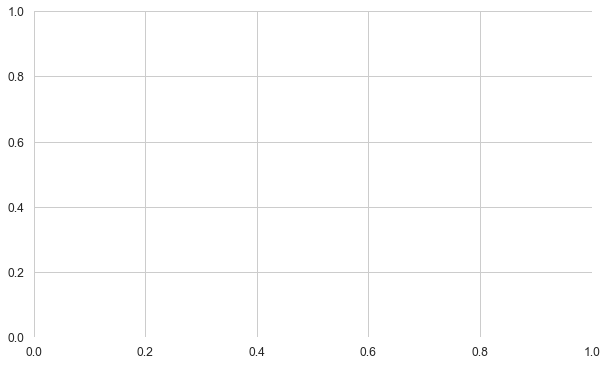

In [157]:
df_hue = df_accuracy[['model', 'classes']].apply(
    lambda row: f'{row.model} CNN, {row.classes} classes', axis=1
)

sns.set(font_scale = 1.1)
sns.set_style("whitegrid")
f, (ax1) = plt.subplots(1, 1, figsize=(10, 6))
sns.despine(left=True, bottom=True)

sns.scatterplot(
            data=df_accuracy,
            x='ratio',
            y='accuracy',
            ax=ax1,
            hue=df_hue,
            palette='colorblind'
        ).set(
            xlabel='false labels ratio (%)',
            ylabel='model accuracy',
            ylim=(0.5,1),
            title='Model Accuracy over False Labels Ratio'
        )
plt.legend(loc='lower left', title='Model Setup', facecolor='white', framealpha=1)

f.savefig('../assets/model_accuracy.png', dpi=300, facecolor='white')

------------

#### weighted avg precision plot

In [ ]:
df_precision_w = df.query("metric == 'weighted avg precision'")
print(df_precision_w.shape)
df_precision_w.head()

In [ ]:
df_hue = df_precision_w[['model', 'classes']].apply(
    lambda row: f'{row.model} CNN, {row.classes} classes', axis=1
)

sns.set(font_scale = 1.1)
sns.set_style("whitegrid")
f, (ax1) = plt.subplots(1, 1, figsize=(10, 6))
sns.despine(left=True, bottom=True)

sns.scatterplot(
            data=df_precision_w,
            x='ratio',
            y='value',
            ax=ax1,
            hue=df_hue,
            palette='colorblind'
        ).set(
            xlabel='false labels ratio (%)',
            ylabel='model precision (weighted)',
            ylim=(0.5,1),
            title='Model Precision (weighted) over False Labels Ratio'
        )
plt.legend(loc='lower left', title='Model Setup', facecolor='white', framealpha=1)

f.savefig('../assets/model_precision.png', dpi=300, facecolor='white')

------------

#### weighted avg recall plot

In [ ]:
df_recall_w = df.query("metric == 'weighted avg recall'")
print(df_recall_w.shape)
df_recall_w.head()

In [ ]:
df_hue = df_recall_w[['model', 'classes']].apply(
    lambda row: f'{row.model} CNN, {row.classes} classes', axis=1
)

sns.set(font_scale = 1.1)
sns.set_style("whitegrid")
f, (ax1) = plt.subplots(1, 1, figsize=(10, 6))
sns.despine(left=True, bottom=True)

sns.scatterplot(
            data=df_recall_w,
            x='ratio',
            y='value',
            ax=ax1,
            hue=df_hue,
            palette='colorblind'
        ).set(
            xlabel='false labels ratio (%)',
            ylabel='model recall (weighted)',
            ylim=(0.5,1),
            title='Model Recall (weighted) over False Labels Ratio'
        )
plt.legend(loc='lower left', title='Model Setup', facecolor='white', framealpha=1)

f.savefig('../assets/model_recall.png', dpi=300, facecolor='white')

------------

#### weighted avg f1-score plot

In [ ]:
df_f1score_w = df.query("metric == 'weighted avg f1-score'")
print(df_f1score_w.shape)
df_f1score_w.head()

In [ ]:
df_hue = df_f1score_w[['model', 'classes']].apply(
    lambda row: f'{row.model} CNN, {row.classes} classes', axis=1
)

sns.set(font_scale = 1.1)
sns.set_style("whitegrid")
f, (ax1) = plt.subplots(1, 1, figsize=(10, 6))
sns.despine(left=True, bottom=True)

sns.scatterplot(
            data=df_f1score_w,
            x='ratio',
            y='value',
            ax=ax1,
            hue=df_hue,
            palette='colorblind'
        ).set(
            xlabel='false labels ratio (%)',
            ylabel='model f1-score (weighted)',
            ylim=(0.5,1),
            title='Model f1-score (weighted) over False Labels Ratio'
        )
plt.legend(loc='lower left', title='Model Setup', facecolor='white', framealpha=1)

f.savefig('../assets/model_f1score.png', dpi=300, facecolor='white')

--------------

## aggregated (mean) metric evaluation

In [ ]:
df_aggr = df.query('metric==["accuracy", "weighted avg precision", "weighted avg recall", "weighted avg f1-score"]')
df_aggr = df_aggr.groupby(['model', 'classes', 'ratio', 'metric']).mean().reset_index()

df_aggr['delta'] = df_aggr.apply(lambda row:
    row['value'] - df_aggr.query(f'model=="{row.model}" & classes=="{row.classes}" & ratio==0.0 & metric=="{row.metric}"').iloc[0]['value'], axis=1
)

df_aggr

--------------

#### aggr accuracy plot

In [ ]:
df_aggr_accuracy = df_aggr.query("metric == 'accuracy'")
df_aggr_accuracy = df_aggr_accuracy.groupby(['model', 'classes', 'ratio', 'metric']).mean().reset_index()
print(df_aggr_accuracy.shape)
df_aggr_accuracy.head()

In [ ]:
df_hue = df_aggr_accuracy[['model', 'classes']].apply(
    lambda row: f'{row.model} CNN, {row.classes} classes', axis=1
)

sns.set(font_scale = 1.1)
sns.set_style("whitegrid")
f, (ax1) = plt.subplots(1, 1, figsize=(10, 6))
sns.despine(left=True, bottom=True)

sns.lineplot(
            data=df_aggr_accuracy,
            x='ratio',
            y='value',
            ax=ax1,
            hue=df_hue,
            palette='colorblind'
        ).set(
            xlabel='false labels ratio (%)',
            ylabel='model accuracy',
            ylim=(0.5,1),
            title='Avg. Model Accuracy over False Labels Ratio'
        )
plt.legend(loc='lower left', title='Model Setup', facecolor='white', framealpha=1)

f.savefig('../assets/avg_model_accuracy.png', dpi=300, facecolor='white')

In [ ]:
df_hue = df_aggr_accuracy[['model', 'classes']].apply(
    lambda row: f'{row.model} CNN, {row.classes} classes', axis=1
)

sns.set(font_scale = 1.1)
sns.set_style("whitegrid")
f, (ax1) = plt.subplots(1, 1, figsize=(10, 6))
sns.despine(left=True, bottom=True)

sns.lineplot(
            data=df_aggr_accuracy,
            x='ratio',
            y='delta',
            ax=ax1,
            hue=df_hue,
            palette='colorblind'
        ).set(
            xlabel='false labels ratio (%)',
            ylabel='model accuracy delta',
            ylim=(-0.2,0.2),
            title='Avg. Model Accuracy Delta over False Labels Ratio'
        )
plt.legend(loc='upper right', title='Model Setup', facecolor='white', framealpha=1)

f.savefig('../assets/avg_model_accuracy_delta.png', dpi=300, facecolor='white')

------------

#### aggr weighted avg precision plot

In [ ]:
df_aggr_precision_w = df_aggr.query("metric == 'weighted avg precision'")
df_aggr_precision_w = df_aggr_precision_w.groupby(['model', 'classes', 'ratio', 'metric']).mean().reset_index()
print(df_aggr_precision_w.shape)
df_aggr_precision_w.head()

In [ ]:
df_hue = df_aggr_precision_w[['model', 'classes']].apply(
    lambda row: f'{row.model} CNN, {row.classes} classes', axis=1
)

sns.set(font_scale = 1.1)
sns.set_style("whitegrid")
f, (ax1) = plt.subplots(1, 1, figsize=(10, 6))
sns.despine(left=True, bottom=True)

sns.lineplot(
            data=df_aggr_precision_w,
            x='ratio',
            y='value',
            ax=ax1,
            hue=df_hue,
            palette='colorblind'
        ).set(
            xlabel='false labels ratio (%)',
            ylabel='model precision (weighted)',
            ylim=(0.5,1),
            title='Avg. Model Precision (weighted) over False Labels Ratio'
        )
plt.legend(loc='lower left', title='Model Setup', facecolor='white', framealpha=1)

f.savefig('../assets/avg_model_precision.png', dpi=300, facecolor='white')

In [ ]:
df_hue = df_aggr_precision_w[['model', 'classes']].apply(
    lambda row: f'{row.model} CNN, {row.classes} classes', axis=1
)

sns.set(font_scale = 1.1)
sns.set_style("whitegrid")
f, (ax1) = plt.subplots(1, 1, figsize=(10, 6))
sns.despine(left=True, bottom=True)

sns.lineplot(
            data=df_aggr_precision_w,
            x='ratio',
            y='delta',
            ax=ax1,
            hue=df_hue,
            palette='colorblind'
        ).set(
            xlabel='false labels ratio (%)',
            ylabel='model precision (weighted) delta',
            ylim=(-0.15,0.15),
            title='Avg. Model Precision (weighted) Delta over False Labels Ratio'
        )
plt.legend(loc='upper right', title='Model Setup', facecolor='white', framealpha=1)

f.savefig('../assets/avg_model_precision_delta.png', dpi=300, facecolor='white')

------------

#### aggr weighted avg recall plot

In [ ]:
df_aggr_recall_w = df_aggr.query("metric == 'weighted avg recall'")
df_recall_w = df_aggr_recall_w.groupby(['model', 'classes', 'ratio', 'metric']).mean().reset_index()
print(df_aggr_recall_w.shape)
df_aggr_recall_w.head()

In [ ]:
df_hue = df_aggr_recall_w[['model', 'classes']].apply(
    lambda row: f'{row.model} CNN, {row.classes} classes', axis=1
)

sns.set(font_scale = 1.1)
sns.set_style("whitegrid")
f, (ax1) = plt.subplots(1, 1, figsize=(10, 6))
sns.despine(left=True, bottom=True)

sns.lineplot(
            data=df_aggr_recall_w,
            x='ratio',
            y='value',
            ax=ax1,
            hue=df_hue,
            palette='colorblind'
        ).set(
            xlabel='false labels ratio (%)',
            ylabel='model recall (weighted)',
            ylim=(0.5,1),
            title='Avg. Model Recall (weighted) over False Labels Ratio'
        )
plt.legend(loc='lower left', title='Model Setup', facecolor='white', framealpha=1)

f.savefig('../assets/avg_model_recall.png', dpi=300, facecolor='white')

In [ ]:
df_hue = df_aggr_recall_w[['model', 'classes']].apply(
    lambda row: f'{row.model} CNN, {row.classes} classes', axis=1
)

sns.set(font_scale = 1.1)
sns.set_style("whitegrid")
f, (ax1) = plt.subplots(1, 1, figsize=(10, 6))
sns.despine(left=True, bottom=True)

sns.lineplot(
            data=df_aggr_recall_w,
            x='ratio',
            y='delta',
            ax=ax1,
            hue=df_hue,
            palette='colorblind'
        ).set(
            xlabel='false labels ratio (%)',
            ylabel='model recall (weighted) delta',
            ylim=(-0.2,0.2),
            title='Avg. Model Recall (weighted) Delta over False Labels Ratio'
        )
plt.legend(loc='upper right', title='Model Setup', facecolor='white', framealpha=1)

f.savefig('../assets/avg_model_recall_delta.png', dpi=300, facecolor='white')

------------

#### aggr weighted avg f1-score plot

In [ ]:
df_aggr_f1score_w = df_aggr.query("metric == 'weighted avg f1-score'")
df_aggr_f1score_w = df_aggr_f1score_w.groupby(['model', 'classes', 'ratio', 'metric']).mean().reset_index()
print(df_aggr_f1score_w.shape)
df_aggr_f1score_w.head()

In [ ]:
df_hue = df_aggr_f1score_w[['model', 'classes']].apply(
    lambda row: f'{row.model} CNN, {row.classes} classes', axis=1
)

sns.set(font_scale = 1.1)
sns.set_style("whitegrid")
f, (ax1) = plt.subplots(1, 1, figsize=(10, 6))
sns.despine(left=True, bottom=True)

sns.lineplot(
            data=df_aggr_f1score_w,
            x='ratio',
            y='value',
            ax=ax1,
            hue=df_hue,
            palette='colorblind'
        ).set(
            xlabel='false labels ratio (%)',
            ylabel='model f1-score (weighted)',
            ylim=(0.5,1),
            title='Avg. Model f1-score (weighted) over False Labels Ratio'
        )
plt.legend(loc='lower left', title='Model Setup', facecolor='white', framealpha=1)

f.savefig('../assets/avg_model_f1score.png', dpi=300, facecolor='white')

In [ ]:
df_hue = df_aggr_f1score_w[['model', 'classes']].apply(
    lambda row: f'{row.model} CNN, {row.classes} classes', axis=1
)

sns.set(font_scale = 1.1)
sns.set_style("whitegrid")
f, (ax1) = plt.subplots(1, 1, figsize=(10, 6))
sns.despine(left=True, bottom=True)

sns.lineplot(
            data=df_aggr_f1score_w,
            x='ratio',
            y='delta',
            ax=ax1,
            hue=df_hue,
            palette='colorblind'
        ).set(
            xlabel='false labels ratio (%)',
            ylabel='model f1-score (weighted) delta',
            ylim=(-0.2,0.2),
            title='Avg. Model f1-score (weighted) Delta over False Labels Ratio'
        )
plt.legend(loc='upper right', title='Model Setup', facecolor='white', framealpha=1)

f.savefig('../assets/avg_model_f1score_delta.png', dpi=300, facecolor='white')